## For Analysis see: 
/glade/work/wchapman/DA_ML/CESML_AI/MJO_Increments/Composite_Phase_Increments


In [1]:
import xarray as xr 
from eofs.xarray import Eof
import eofs.standard as Eof_st
import time
import glob
import dask
import copy
import numpy as np
import pandas as pd
import os
import random


import matplotlib.pyplot as plt
import matplotlib as mpl
#import collections
import matplotlib.ticker as mticker
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.crs as ccrs
import cartopy as cart
import cartopy.mpl.ticker as cticker
import cartopy.feature as cfeature
from matplotlib.colors import ListedColormap
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import cmocean
import scipy as sp

In [2]:
print('...setting up dask client...')
if 'client' in locals():
    client.shutdown()
    print('...shutdown client...')
else:
    print('client does not exist yet')

...setting up dask client...
client does not exist yet


In [3]:
# ### ++++++ dask NCAR client: 
from distributed import Client
from dask_jobqueue import PBSCluster
project_num = 'P03010039' #what project key do you have? 

cluster = PBSCluster(account=project_num,walltime='12:00:00',cores=1, memory='40GB',shared_temp_directory='/glade/derecho/scratch/wchapman/tmp',queue='casper')
cluster.scale(jobs=40)
client = Client(cluster)

## Get the Bom Index

In [8]:
# Define the path to the NOAA data file. This file contains observations related to the Madden-Julian Oscillation.
pth_txt = '/glade/work/wchapman/MJOcast/MJOcast/Observations/BOM_INDEX.txt'

# Load the data from the specified path using pandas. The data is expected to be whitespace-delimited.
dataNOAA = pd.read_csv(pth_txt, delimiter='\s+', header=0)

# Rename the columns for clarity and future reference. 
# It includes date components (year, month, day), RMM1 and RMM2 indices, phase, amplitude, and an unused 'doggy' column.
dataNOAA.columns = ["year", "month", "day", "RMM1", "RMM2", "phase", 'amplitude', 'doggy']

# Remove the 'doggy' column as it's not relevant for our analysis.
dataNOAA.drop(columns='doggy', inplace=True)

# Create a new column 'time' by combining 'year', 'month', and 'day' into a datetime object.
# This will allow for time-based indexing and operations within the dataset.
dataNOAA['time'] = pd.to_datetime(dataNOAA[['year', 'month', 'day']])

# Drop the original year, month, and day columns as they're now redundant with the 'time' column in place.
dataNOAA.drop(columns=['year', 'month', 'day'], inplace=True)

# Set the 'time' column as the DataFrame's index. 
# This is a preparatory step for conversion to xarray, facilitating time-series analysis.
dataNOAA.set_index('time', inplace=True)

# Convert the prepared pandas DataFrame to an xarray Dataset.
# This transformation leverages the datetime-indexed DataFrame to structure the dataset for multidimensional analysis.
ds = xr.Dataset.from_dataframe(dataNOAA)
ds = ds.sel(time=slice('2000','2008'))
ds['phase'] = ds['phase'].where(ds['amplitude'] >= 1, 0)
ds

<xarray.Dataset>
Dimensions:    (time: 3288)
Coordinates:
  * time       (time) datetime64[ns] 2000-01-01 2000-01-02 ... 2008-12-31
Data variables:
    RMM1       (time) float64 -0.3729 -0.4177 -0.3662 ... 0.8394 0.9724 0.9158
    RMM2       (time) float64 -0.08401 -0.1621 -0.3298 ... 0.2618 0.6397 0.7483
    phase      (time) int64 0 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 4 5 5 0 5 5
    amplitude  (time) float64 0.3822 0.4481 0.4929 0.5835 ... 0.8793 1.164 1.183

## Open All Of the Increment Files in Parallel:

In [6]:
FNS = sorted(glob.glob('/glade/campaign/cgd/amp/wchapman/DA_ML/CESML_AI/Data/daychunks/f.e21.DAcompset.sppt_stochai_Nudge_UV_2000.cam.h1.200*.nc'))
DS1=xr.open_mfdataset(FNS,parallel=True)[['Nudge_U','Nudge_V']]
DS1

## Get Mean over NDJFMA

In [ ]:
%%time 
DS1=DS1.chunk({'time':30})
NDJFM_DS1 = DS1.where((DS1['time.month'] >= 11) | (DS1['time.month'] <= 4), drop=True)
print('loading time mean')
NDJFM_DS1_mean = NDJFM_DS1.mean('time').load()
NDJFM_DS1_mean = NDJFM_DS1_mean.rename({'Nudge_U':'NDJFM_U','Nudge_V':'NDJFM_V'})

## Composite by Phase

In [19]:
%%time
mean_phase_u=[]
mean_phase_v=[]
stphas=1
endphas=9
len_per = []

for pp in range(stphas, endphas):
    print('phaser: ', pp)
    ds = ds.sel(time=slice('2000', '2007'))
    filtered_ds = ds.where(ds['phase'] == pp, drop=True)
    filtered_ds = filtered_ds.where((filtered_ds['time.month'] >= 11) | (filtered_ds['time.month'] <= 4), drop=True)
    filtered_ds
    # get all the DS
    DS_all = []
    for ee, tt in enumerate(filtered_ds['time']):
        tstr = str(np.array(tt))[:10]
        if ee % 50 == 0:
            print(ee, 'of', len(filtered_ds['time']))
        try:
            DS_all.append(DS1.sel(time=tstr).mean('time').load())
        except:
            print('pass', tstr)

    nudge_u_list = [ds['Nudge_U'] for ds in DS_all]
    indnan =[]
    for ee,nn in enumerate(nudge_u_list):
        nnans = np.array(np.sum(np.isnan((nudge_u_list[ee]))))
        if nnans>0:
            indnan.append(ee)
    indices_to_remove = indnan
    # Sort the indices in descending order to avoid index shifting
    for index in sorted(indices_to_remove, reverse=True):
        nudge_u_list.pop(index)

    mean_nudge_u = sum(nudge_u_list)/len(nudge_u_list)
    nudge_v_list = [ds['Nudge_V'] for ds in DS_all]
    indnan =[]
    for ee,nn in enumerate(nudge_v_list):
        nnans = np.array(np.sum(np.isnan((nudge_v_list[ee]))))
        if nnans>0:
            indnan.append(ee)
    indices_to_remove = indnan
    # Sort the indices in descending order to avoid index shifting
    for index in sorted(indices_to_remove, reverse=True):
        nudge_v_list.pop(index)
    mean_nudge_v = sum(nudge_v_list)/len(nudge_v_list)

    mean_phase_u.append(mean_nudge_u)
    mean_phase_v.append(mean_nudge_v)
    len_per.append(len(nudge_u_list))

# Assuming mean_phase_u and mean_phase_v are lists of xarray DataArrays
# Create a coordinate array for "phase"
phases = np.arange(stphas, endphas)  # Adjust the range as necessary

# Combine mean_phase_u and mean_phase_v into DataArrays with "phase" as a new coordinate
mean_phase_u_da = xr.concat(mean_phase_u, dim='phase')
mean_phase_v_da = xr.concat(mean_phase_v, dim='phase')

# # Assign the "phase" coordinate
mean_phase_u_da['phase'] = phases
mean_phase_v_da['phase'] = phases

Phase_Incs = xr.merge([mean_phase_v_da, mean_phase_u_da])
Phase_Incs = xr.merge([Phase_Incs,NDJFM_DS1_mean])
Phase_Incs.to_netcdf('./Increments_by_Phase.nc')
len_per

[61, 107, 148, 113, 123, 126, 91, 97]

## 8 Panel Plot

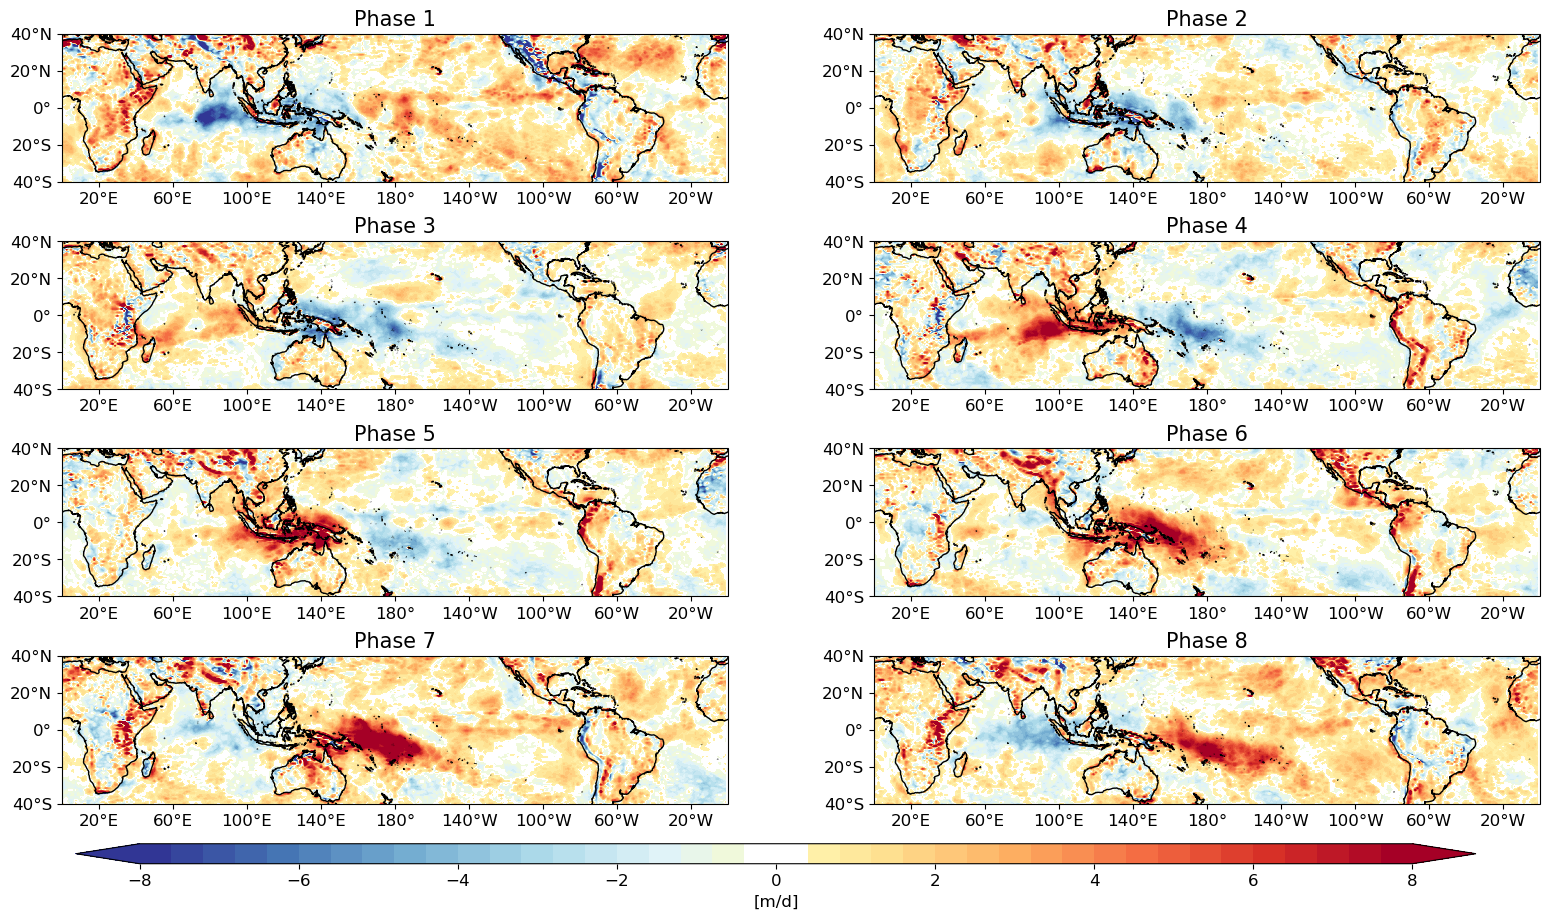

In [10]:
Phase_Incs = xr.open_dataset('./Increments_by_Phase_nozero.nc')

# Setup remains largely the same
# Define clevs and colormap for your data here
# Parameters and data setup (remains the same)
clevs = np.arange(-8, 8.4, .4)
bluey = mpl.cm.get_cmap('RdYlBu_r', len(clevs))
newcolors = bluey(np.linspace(0, 1, len(clevs)))
nnn = int(np.floor(newcolors.shape[0]/2))
newcolors[nnn] = newcolors[nnn]/newcolors[nnn]
newcolors[nnn+1] = newcolors[nnn+1]/newcolors[nnn+1]
newcolors[nnn-1] = newcolors[nnn-1]/newcolors[nnn-1]
cmapzzz = ListedColormap(newcolors)

#begin fig
fig = plt.figure(figsize=(20, 10))  # Adjusted figure size for 8 panels
proj = ccrs.PlateCarree(central_longitude=180)

lvlv = 1000
varvar = 'Nudge_U'
varvarm = 'NDJFM_U'
for phs in range(1,9):
    ax = plt.subplot(4, 2, phs, projection=proj)  # Dynamic subplot creation
    ax.coastlines('50m')

   
    pfield = ((Phase_Incs[varvar].sel(phase=phs, lev=lvlv, method='nearest')-Phase_Incs.sel(lev=lvlv, method='nearest')[varvarm])*86400)

    # Plotting
    bb = ax.contourf(pfield['lon'] - 180, pfield['lat'], pfield, levels=clevs, cmap=cmapzzz, transform=proj, extend='both')
    
    # Set ticks, labels, and title dynamically
    ax.set_xticks([20, 60, 100, 140, 180, 220, 260, 300, 340], crs=ccrs.PlateCarree())
    ax.set_yticks(np.arange(-60, 70, 20), crs=ccrs.PlateCarree())
    ax.xaxis.set_major_formatter(LongitudeFormatter(zero_direction_label=True, number_format='.0f'))
    ax.yaxis.set_major_formatter(LatitudeFormatter())
    ax.tick_params(labelsize=12)
    ax.set_extent([0, 360, -40, 40], crs=ccrs.PlateCarree())
    ax.set_title(f'Phase {phs}', fontsize=15)  # Dynamic title

    
# Add a colorbar at the bottom of the figure
# Use the axes_list for positioning
cbar_ax = fig.add_axes([0.15, 0.05, 0.7, 0.02])  # [left, bottom, width, height] in figure coordinate
cbar=fig.colorbar(bb, cax=cbar_ax, orientation='horizontal', label='[m/d]')
cbar.ax.tick_params(labelsize=12)
cbar.set_label(label='[m/d]',fontsize=12)
fig.subplots_adjust(hspace=0.4,wspace=0.1)  # Adjust spacing as needed
plt.show()


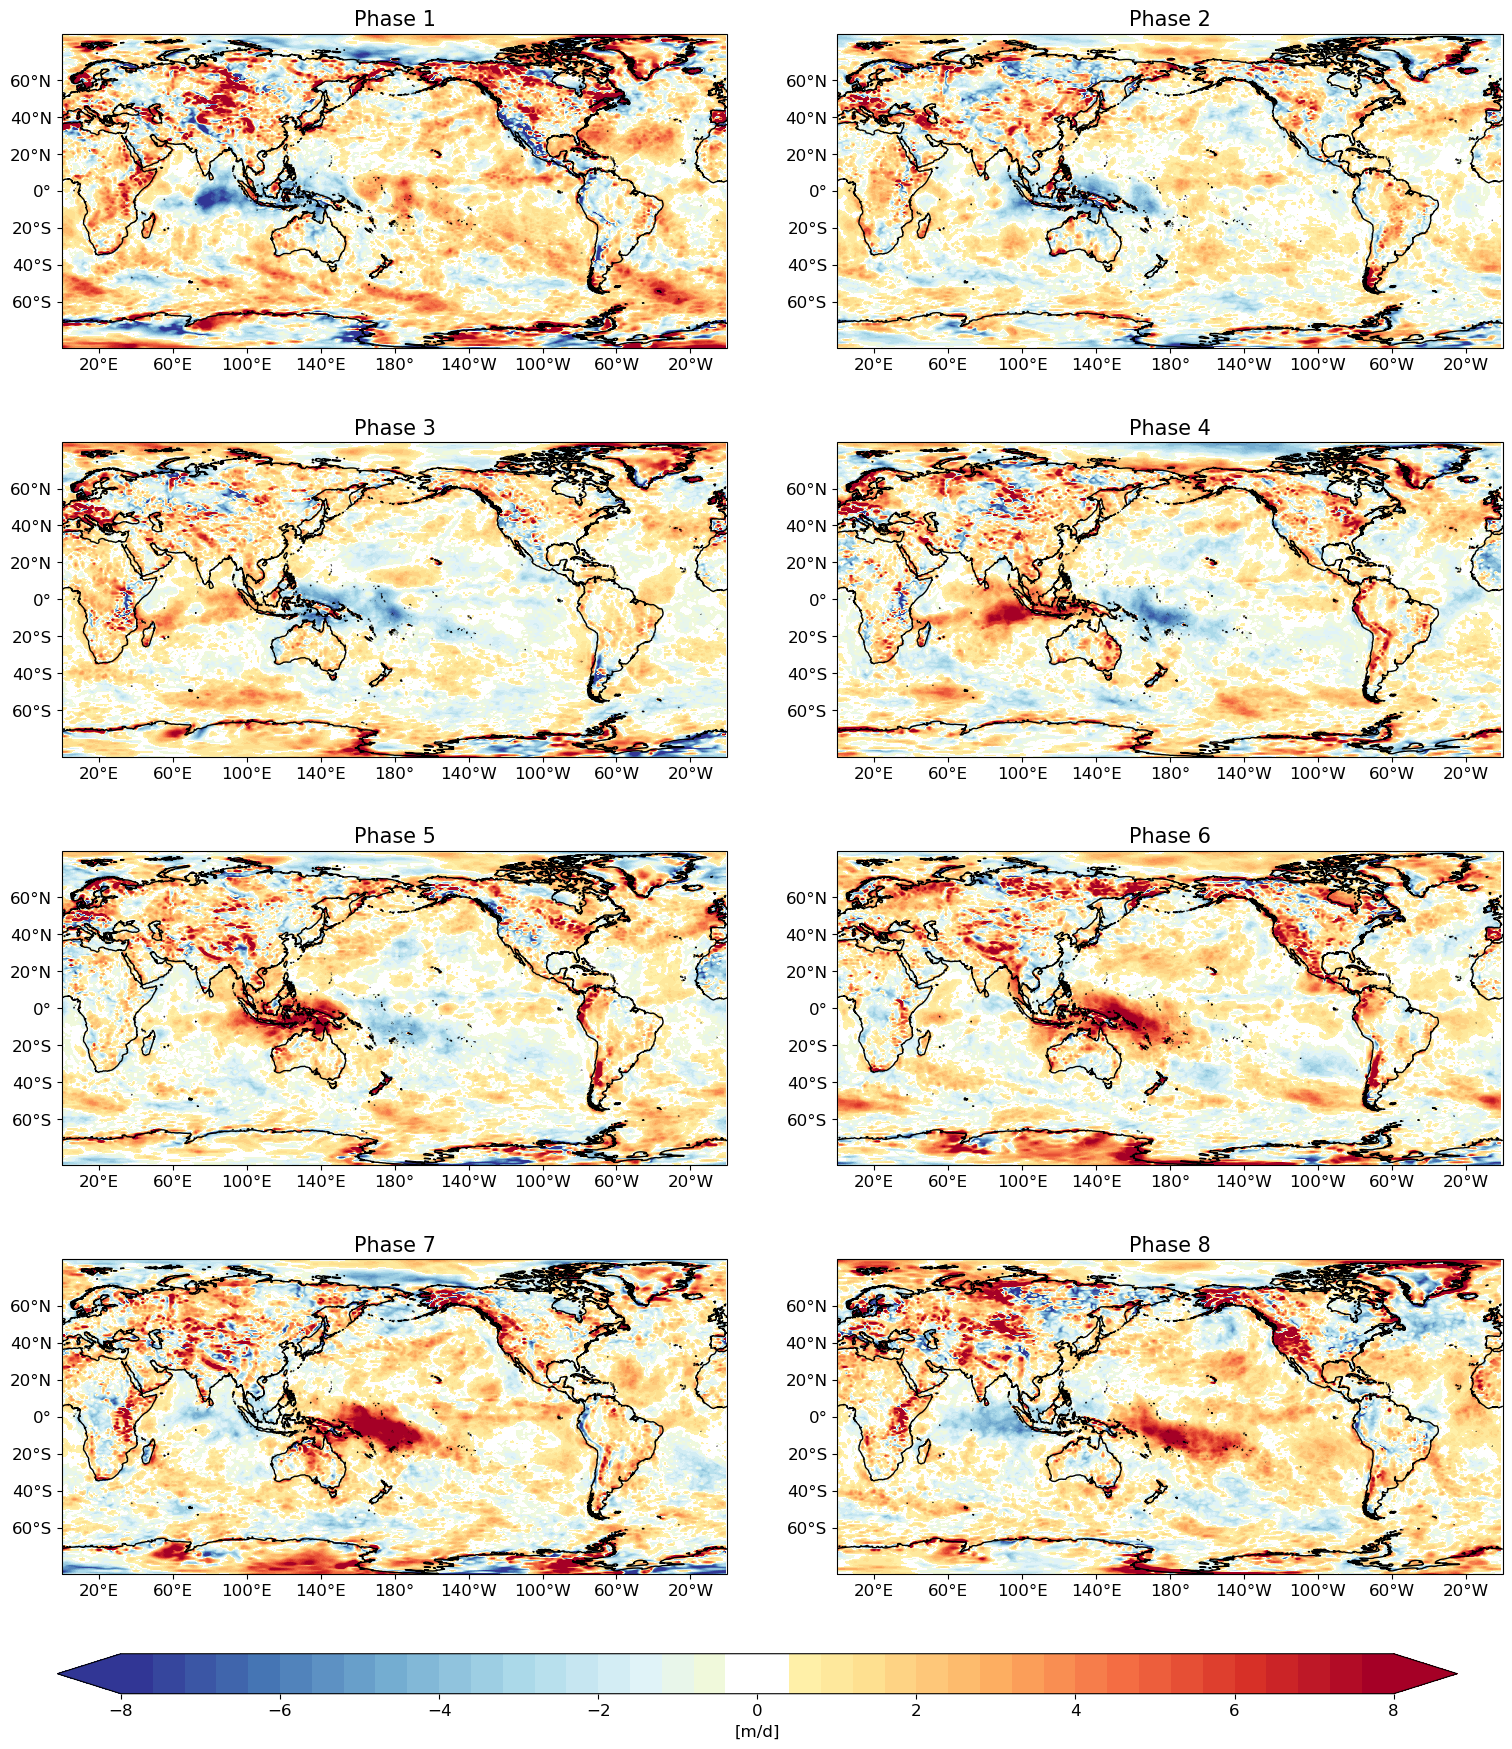

In [11]:
# Setup remains largely the same
# Define clevs and colormap for your data here
# Parameters and data setup (remains the same)
clevs = np.arange(-8, 8.4, .4)
bluey = mpl.cm.get_cmap('RdYlBu_r', len(clevs))
newcolors = bluey(np.linspace(0, 1, len(clevs)))
nnn = int(np.floor(newcolors.shape[0]/2))
newcolors[nnn] = newcolors[nnn]/newcolors[nnn]
newcolors[nnn+1] = newcolors[nnn+1]/newcolors[nnn+1]
newcolors[nnn-1] = newcolors[nnn-1]/newcolors[nnn-1]
cmapzzz = ListedColormap(newcolors)

#begin fig
fig = plt.figure(figsize=(20, 20))  # Adjusted figure size for 8 panels
proj = ccrs.PlateCarree(central_longitude=180)

lvlv = 1000
varvar = 'Nudge_U'
varvarm = 'NDJFM_U'
for phs in range(1,9):
    ax = plt.subplot(4, 2, phs, projection=proj)  # Dynamic subplot creation
    ax.coastlines('50m')

   
    pfield = ((Phase_Incs[varvar].sel(phase=phs, lev=lvlv, method='nearest')-Phase_Incs.sel(lev=lvlv, method='nearest')[varvarm])*86400)

    # Plotting
    bb = ax.contourf(pfield['lon'] - 180, pfield['lat'], pfield, levels=clevs, cmap=cmapzzz, transform=proj, extend='both')
    
    # Set ticks, labels, and title dynamically
    ax.set_xticks([20, 60, 100, 140, 180, 220, 260, 300, 340], crs=ccrs.PlateCarree())
    ax.set_yticks(np.arange(-60, 70, 20), crs=ccrs.PlateCarree())
    ax.xaxis.set_major_formatter(LongitudeFormatter(zero_direction_label=True, number_format='.0f'))
    ax.yaxis.set_major_formatter(LatitudeFormatter())
    ax.tick_params(labelsize=12)
    ax.set_extent([0, 360, -85, 85], crs=ccrs.PlateCarree())
    ax.set_title(f'Phase {phs}', fontsize=15)  # Dynamic title

    
# Add a colorbar at the bottom of the figure
# Use the axes_list for positioning
cbar_ax = fig.add_axes([0.15, 0.05, 0.7, 0.02])  # [left, bottom, width, height] in figure coordinate
cbar=fig.colorbar(bb, cax=cbar_ax, orientation='horizontal', label='[m/d]')
cbar.ax.tick_params(labelsize=12)
cbar.set_label(label='[m/d]',fontsize=12)
fig.subplots_adjust(hspace=0.3,wspace=0.001)  # Adjust spacing as needed
plt.show()


## Significance Test
There must be a faster way to do this

In [25]:
def sample_dates_uniformly(utart, sels):
    # Convert string dates to datetime objects for easier manipulation
    dates = np.array([np.datetime64(date) for date in utart])
    all_selected_dates = []
    
    # Determine the number of sequences to attempt to select, aiming for a mix of individual and sequences
    num_sequences = sels // 4  # Roughly aiming for 1/4 of selections to be sequences
    
    for _ in range(num_sequences):
        # Choose a sequence length between 3 to 8
        seq_length = random.randint(2, 6)
        # Ensure selection is uniformly distributed
        start_index = random.randint(0, len(dates) - seq_length)
        sequence = dates[start_index:start_index + seq_length]
        
        # Add this sequence to our selections if it doesn't overlap with existing selections
        if not any(date in all_selected_dates for date in sequence):
            all_selected_dates.extend(sequence)
    
    # Fill the rest of the selections with individual days
    while len(all_selected_dates) < sels:
        potential_date = np.random.choice(dates)
        if potential_date not in all_selected_dates:
            all_selected_dates.append(potential_date)
    
    # Ensure the selected dates do not exceed the sels and sort them
    selected_dates_sorted = sorted(all_selected_dates)[:sels]
    
    return [np.datetime_as_string(d, unit='D') for d in selected_dates_sorted]


In [12]:
%%time
bsnummy = 200
for sels in len_per:
    DSsum_all = []
    
    tart = NDJFM_DS1['time'].dt.strftime('%Y-%m-%d').values
    utart = np.unique(tart)
        
    for bsbs in range(bsnummy):
        print('iteration: ',bsbs)
        list_of_random_items =  sample_dates_uniformly(sorted(utart),sels)
        DS_all=[]
        
        for ee, tt in enumerate(list_of_random_items):
            tstr = tt
            try:
                DS_all.append(NDJFM_DS1.sel(time=tstr).mean('time'))
            except:
                print('pass', tstr)
        DSsum = sum(DS_all)
        DSsum.load()
        if DSsum is not None and np.isnan(DSsum['Nudge_U']).sum() > 0:
            print('nantown')
            break
        DSsum_all.append(DSsum)
    
        if (bsbs+1) % 50 == 0:
            print('...saving out...')
            bootstrap = np.arange(len(DSsum_all))
            DSsum_save = xr.concat(DSsum_all,dim='bootstrap')
            DSsum_save['bootstrap']=bootstrap
            DSsum_save.to_netcdf(f'./sum_sequence_nozero_save_BSincrements_{bsbs:04}_{sels:04}.nc')

## Apply Significance test files and save out
[61, 107, 148, 113, 123, 126, 91, 97]

In [6]:
flist_siggy = ['./sum_sequence_nozero_save_BSincrements_0199_0061.nc',
               './sum_sequence_nozero_save_BSincrements_0199_0107.nc',
               './sum_sequence_nozero_save_BSincrements_0199_0148.nc',
               './sum_sequence_nozero_save_BSincrements_0199_0113.nc',
               './sum_sequence_nozero_save_BSincrements_0199_0123.nc',
               './sum_sequence_nozero_save_BSincrements_0199_0126.nc',
               './sum_sequence_nozero_save_BSincrements_0199_0091.nc',
               './sum_sequence_nozero_save_BSincrements_0199_0097.nc']
# Define the Gaussian function for scaling the params 
# around the equator:
def gaussian_scale(x, mu, sigma):
    return np.exp(-(x - mu)**2 / (2 * sigma**2))
# Matrix dimensions
lat_dim = 192 
# Latitude indices
xt = np.linspace(0, lat_dim - 1, lat_dim)
# Mean (centered at the equator)
mu = (lat_dim - 1) / 2
sigma = 25   # Example sigma value, adjust as needed
scale_factor = gaussian_scale(xt, mu, sigma)[:, None]  # Reshape for broadcasting
# scaled_matrix = scale_factor * x
scale_factor[scale_factor>0.8]=1

for dofil in range(7,8):
    DS = xr.open_dataset(flist_siggy[dofil])
    DS=DS/float(flist_siggy[dofil].split('_')[-1].split('.nc')[0])
    # DSmean = xr.open_dataset('./Increments_by_Phase.nc')
    DSmean = xr.open_dataset('./Increments_by_Phase_nozero.nc')
    
    Xfil = xr.zeros_like(DS[['Nudge_U','Nudge_V']].isel(bootstrap=0))
    
    
    # scaled_matrix = scale_factor * x
    
    for ee, lv in enumerate(Xfil['lev']):
        lv = np.array(lv)
        print('doing lev:',lv)
        qhi=.95
        qlo=.05
        vv = 'Nudge_V'
        vvm = 'NDJFM_V'
        DSq = (DS.sel(lev=lv,method='nearest')[vv]-DSmean.sel(lev=lv,method='nearest')[vvm]).quantile(q=[qhi,qlo],dim='bootstrap')
        Dphs = (DSmean[vv].sel(phase=dofil+1,lev=lv,method='nearest')-DSmean.sel(lev=lv,method='nearest')[vvm])
    
        x_v = np.array(((((Dphs*86400)>(DSq.sel(quantile=qhi)*86400))*1)+(((Dphs*86400)<(DSq.sel(quantile=qlo)*86400))*1)))
        sigma_y = 1
        sigma_x = 1
        # Apply gaussian filter
        sigma = [sigma_y, sigma_x]
        y_v = sp.ndimage.gaussian_filter(x_v.astype('float64'), sigma, mode='constant')
    
        y_v =scale_factor*y_v
        Xfil['Nudge_V'].sel(lev=lv, method='nearest')[:,:] = y_v * Dphs[:,:]
    
        vv = 'Nudge_U'
        vvm = 'NDJFM_U'
        DSq = (DS.sel(lev=lv, method='nearest')[vv]-DSmean.sel(lev=lv, method='nearest')[vvm]).quantile(q = [qhi,qlo], dim='bootstrap')
        Dphs = (DSmean[vv].sel(phase=dofil+1, lev=lv, method='nearest')-DSmean.sel(lev=lv, method='nearest')[vvm])
    
        x_u = np.array(((((Dphs*86400) > (DSq.sel(quantile=qhi)*86400))*1) + (((Dphs*86400)<(DSq.sel(quantile = qlo)*86400))*1)))
    
        sigma_y = 1
        sigma_x = 1
        # Apply gaussian filter
        sigma = [sigma_y, sigma_x]
        y_u = sp.ndimage.gaussian_filter(x_u.astype('float64'), sigma, mode='constant')
    
        y_u=scale_factor*y_u
        Xfil['Nudge_U'].sel(lev=lv, method='nearest')[:,:] = y_u * Dphs[:,:]
        Xfil.to_netcdf(f"./MJO_phase_increment_{dofil+1:03}.nc",format="NETCDF3_CLASSIC")

## Every thing:

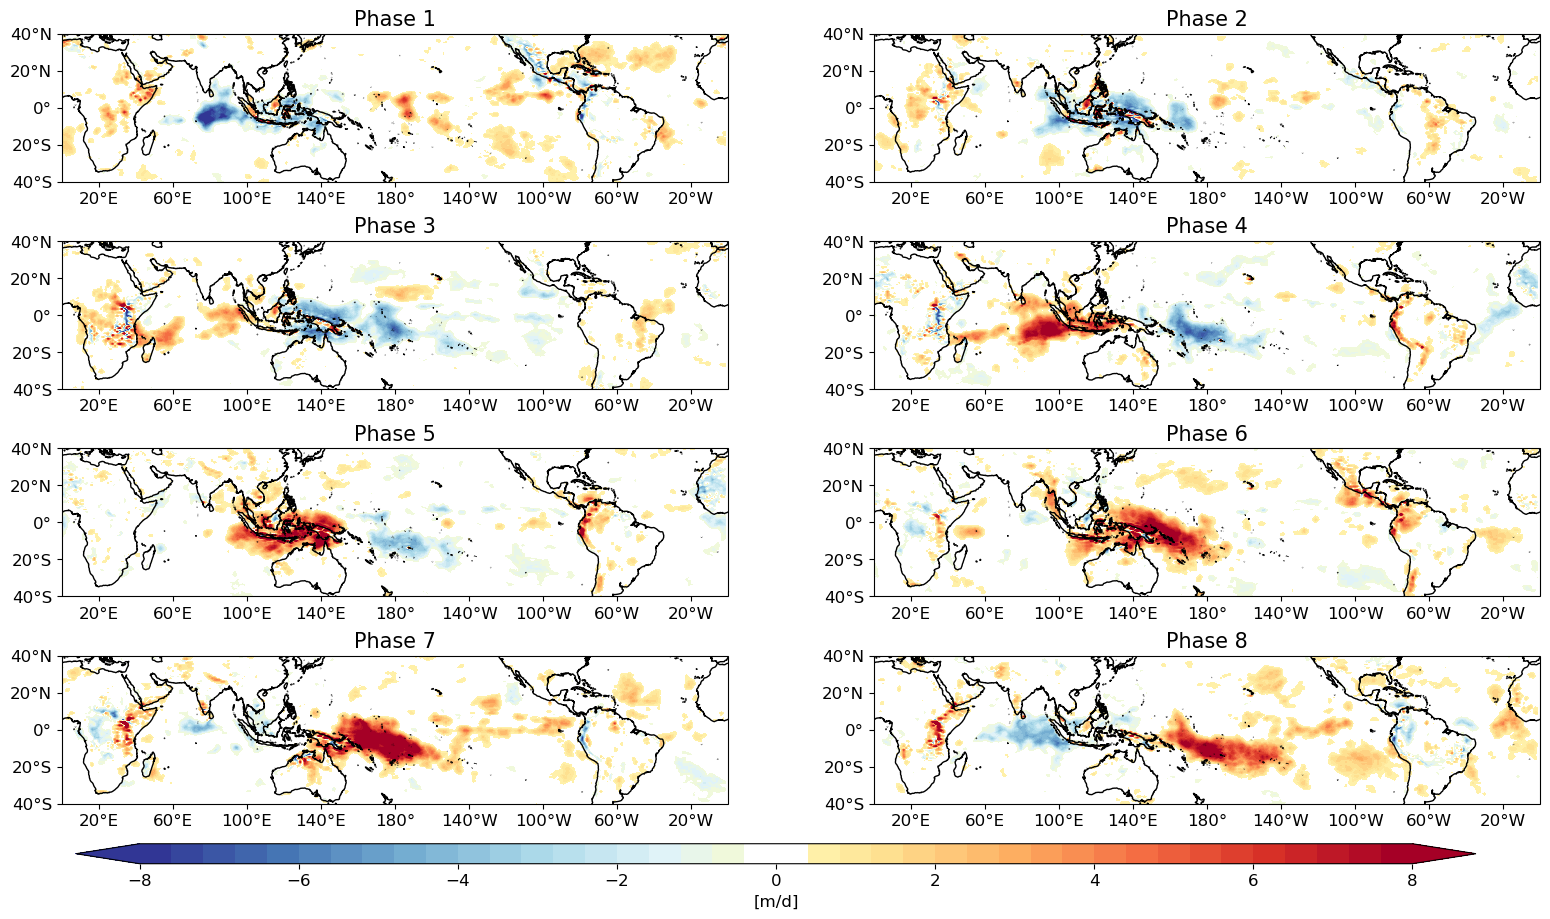

In [7]:
# Setup remains largely the same
# Define clevs and colormap for your data here
# Parameters and data setup (remains the same)
clevs = np.arange(-8, 8.4, .4)
bluey = mpl.cm.get_cmap('RdYlBu_r', len(clevs))
newcolors = bluey(np.linspace(0, 1, len(clevs)))
nnn = int(np.floor(newcolors.shape[0]/2))
newcolors[nnn] = newcolors[nnn]/newcolors[nnn]
newcolors[nnn+1] = newcolors[nnn+1]/newcolors[nnn+1]
newcolors[nnn-1] = newcolors[nnn-1]/newcolors[nnn-1]
cmapzzz = ListedColormap(newcolors)

#begin fig
fig = plt.figure(figsize=(20, 10))  # Adjusted figure size for 8 panels
proj = ccrs.PlateCarree(central_longitude=180)

lvlv = 1000
varvar = 'Nudge_U'
for phs in range(1,9):
    Phase_Incs = xr.open_dataset(f"./MJO_phase_increment_{phs:03}.nc")
    ax = plt.subplot(4, 2, phs, projection=proj)  # Dynamic subplot creation
    ax.coastlines('50m')

   
    pfield = ((Phase_Incs[varvar].sel(lev=lvlv, method='nearest'))*86400)

    # Plotting
    bb = ax.contourf(pfield['lon'] - 180, pfield['lat'], pfield, levels=clevs, cmap=cmapzzz, transform=proj, extend='both')
    
    # Set ticks, labels, and title dynamically
    ax.set_xticks([20, 60, 100, 140, 180, 220, 260, 300, 340], crs=ccrs.PlateCarree())
    ax.set_yticks(np.arange(-60, 70, 20), crs=ccrs.PlateCarree())
    ax.xaxis.set_major_formatter(LongitudeFormatter(zero_direction_label=True, number_format='.0f'))
    ax.yaxis.set_major_formatter(LatitudeFormatter())
    ax.tick_params(labelsize=12)
    ax.set_extent([0, 360, -40, 40], crs=ccrs.PlateCarree())
    ax.set_title(f'Phase {phs}', fontsize=15)  # Dynamic title

    
# Add a colorbar at the bottom of the figure
# Use the axes_list for positioning
cbar_ax = fig.add_axes([0.15, 0.05, 0.7, 0.02])  # [left, bottom, width, height] in figure coordinate
cbar=fig.colorbar(bb, cax=cbar_ax, orientation='horizontal', label='[m/d]')
cbar.ax.tick_params(labelsize=12)
cbar.set_label(label='[m/d]',fontsize=12)
fig.subplots_adjust(hspace=0.4,wspace=0.1)  # Adjust spacing as needed
plt.show()

## Let's Add UV winds

In [10]:
FNS = sorted(glob.glob('/glade/campaign/cgd/amp/wchapman/DA_ML/CESML_AI/Data/daychunks/f.e21.DAcompset.sppt_stochai_Nudge_UV_2000.cam.h1.200*.nc'))
DS1=xr.open_mfdataset(FNS,parallel=True)[['U','V']]
DS1

<xarray.Dataset>
Dimensions:  (time: 69961, lev: 32, lat: 192, lon: 288)
Coordinates:
  * lat      (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 87.17 88.12 89.06 90.0
  * lon      (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * lev      (lev) float64 3.643 7.595 14.36 24.61 ... 936.2 957.5 976.3 992.6
  * time     (time) object 2000-01-01 00:00:00 ... 2007-12-31 23:00:00
Data variables:
    U        (time, lev, lat, lon) float64 dask.array<chunksize=(120, 32, 192, 288), meta=np.ndarray>
    V        (time, lev, lat, lon) float64 dask.array<chunksize=(120, 32, 192, 288), meta=np.ndarray>
Attributes:
    Conventions:       CF-1.0
    source:            CAM
    case:              f.e21.DAcompset.sppt_stochai_Nudge_UV_2000
    logname:           wchapman
    host:              derecho5
    initial_file:      f.e20.FHIST.f09_f09.cesm2_1.001_v2.cam.i.2000-01-01-00...
    topography_file:   /glade/campaign/cesm/cesmdata/inputdata/atm/cam/topo/f...
    model_doi_url:     https://doi.org/10.5065/D67H1H0V
    time_period_freq:  hour_1

## Get the Mean over the NDJFM

In [11]:
%%time 
DS1=DS1.chunk({'time':30})
NDJFM_DS1 = DS1.where((DS1['time.month'] >= 11) | (DS1['time.month'] <= 4), drop=True)
print('loading time mean')
NDJFM_DS1_mean = NDJFM_DS1.mean('time').load()
NDJFM_DS1_mean = NDJFM_DS1_mean.rename({'U':'NDJFM_Um','V':'NDJFM_Vm'})

loading time mean
CPU times: user 13.8 s, sys: 957 ms, total: 14.8 s
Wall time: 2min 16s


## Get UV by phase:

In [12]:
%%time
mean_phase_u=[]
mean_phase_v=[]
stphas=1
endphas=9
len_per = []

for pp in range(stphas, endphas):
    print('phaser: ', pp)
    ds = ds.sel(time=slice('2000', '2007'))
    filtered_ds = ds.where(ds['phase'] == pp, drop=True)
    filtered_ds = filtered_ds.where((filtered_ds['time.month'] >= 11) | (filtered_ds['time.month'] <= 4), drop=True)
    filtered_ds
    # get all the DS
    DS_all = []
    for ee, tt in enumerate(filtered_ds['time']):
        tstr = str(np.array(tt))[:10]
        if ee % 50 == 0:
            print(ee, 'of', len(filtered_ds['time']))
        try:
            DS_all.append(DS1.sel(time=tstr).mean('time').load())
        except:
            print('pass', tstr)

    nudge_u_list = [ds['U'] for ds in DS_all]
    indnan =[]
    for ee,nn in enumerate(nudge_u_list):
        nnans = np.array(np.sum(np.isnan((nudge_u_list[ee]))))
        if nnans>0:
            indnan.append(ee)
    indices_to_remove = indnan
    # Sort the indices in descending order to avoid index shifting
    for index in sorted(indices_to_remove, reverse=True):
        nudge_u_list.pop(index)

    mean_nudge_u = sum(nudge_u_list)/len(nudge_u_list)
    nudge_v_list = [ds['V'] for ds in DS_all]
    indnan =[]
    for ee,nn in enumerate(nudge_v_list):
        nnans = np.array(np.sum(np.isnan((nudge_v_list[ee]))))
        if nnans>0:
            indnan.append(ee)
    indices_to_remove = indnan
    # Sort the indices in descending order to avoid index shifting
    for index in sorted(indices_to_remove, reverse=True):
        nudge_v_list.pop(index)
    mean_nudge_v = sum(nudge_v_list)/len(nudge_v_list)

    mean_phase_u.append(mean_nudge_u)
    mean_phase_v.append(mean_nudge_v)
    len_per.append(len(nudge_u_list))

# Assuming mean_phase_u and mean_phase_v are lists of xarray DataArrays
# Create a coordinate array for "phase"
phases = np.arange(stphas, endphas)  # Adjust the range as necessary

# Combine mean_phase_u and mean_phase_v into DataArrays with "phase" as a new coordinate
mean_phase_u_da = xr.concat(mean_phase_u, dim='phase')
mean_phase_v_da = xr.concat(mean_phase_v, dim='phase')

# # Assign the "phase" coordinate
mean_phase_u_da['phase'] = phases
mean_phase_v_da['phase'] = phases

Phase_Incs = xr.merge([mean_phase_v_da, mean_phase_u_da])
Phase_Incs = xr.merge([Phase_Incs,NDJFM_DS1_mean])
Phase_Incs.to_netcdf('./Increments_by_Phase_UV.nc')
len_per

phaser:  1
0 of 61
50 of 61
phaser:  2
0 of 107
50 of 107
100 of 107
phaser:  3
0 of 148
50 of 148
100 of 148
phaser:  4
0 of 114
pass 2000-02-29
50 of 114
100 of 114
phaser:  5
0 of 124
50 of 124
pass 2004-02-29
100 of 124
phaser:  6
0 of 126
50 of 126
100 of 126
phaser:  7
0 of 93
50 of 93
phaser:  8
0 of 98
50 of 98
CPU times: user 1min 57s, sys: 24.9 s, total: 2min 22s
Wall time: 36min 39s


[61, 107, 148, 113, 123, 126, 91, 97]

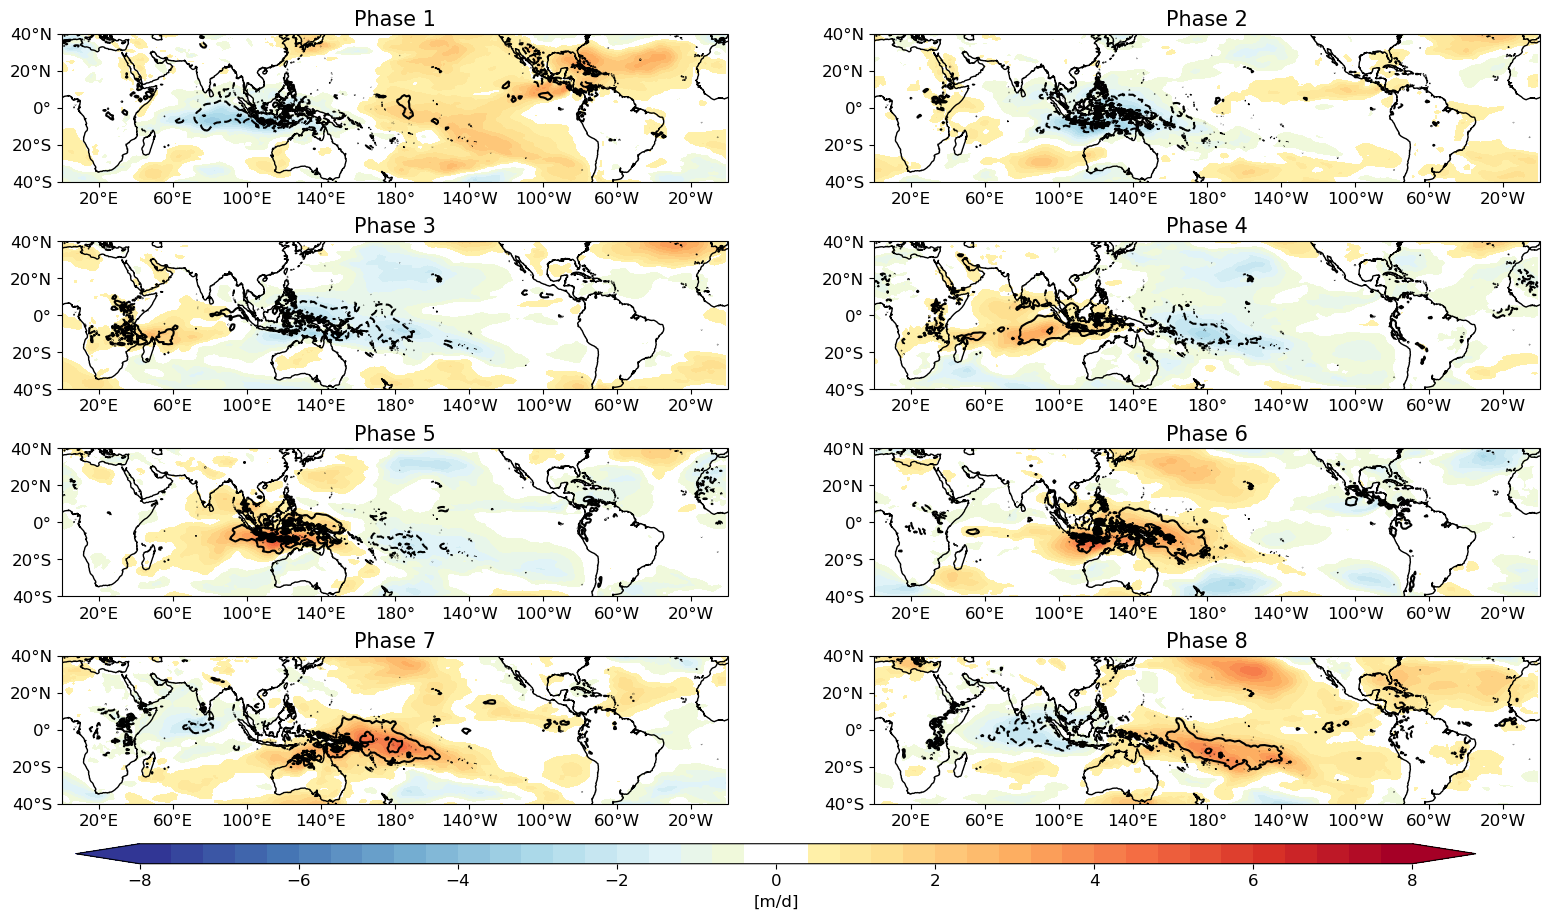

In [81]:
Phase_Incs = xr.open_dataset('./Increments_by_Phase_UV.nc')

# Setup remains largely the same
# Define clevs and colormap for your data here
# Parameters and data setup (remains the same)
clevs = np.arange(-8, 8.4, .4)
bluey = mpl.cm.get_cmap('RdYlBu_r', len(clevs))
newcolors = bluey(np.linspace(0, 1, len(clevs)))
nnn = int(np.floor(newcolors.shape[0]/2))
newcolors[nnn] = newcolors[nnn]/newcolors[nnn]
newcolors[nnn+1] = newcolors[nnn+1]/newcolors[nnn+1]
newcolors[nnn-1] = newcolors[nnn-1]/newcolors[nnn-1]
cmapzzz = ListedColormap(newcolors)

#begin fig
fig = plt.figure(figsize=(20, 10))  # Adjusted figure size for 8 panels
proj = ccrs.PlateCarree(central_longitude=180)

lvlv = 1000
varvar = 'U'
varvarm = 'NDJFM_Um'
for phs in range(1,9):
    Phase_Incs_mjo = xr.open_dataset(f"./MJO_phase_increment_{phs:03}.nc")
    ax = plt.subplot(4, 2, phs, projection=proj)  # Dynamic subplot creation
    ax.coastlines('50m')

   
    pfield = ((Phase_Incs[varvar].sel(phase=phs, lev=lvlv, method='nearest')-Phase_Incs.sel(lev=lvlv, method='nearest')[varvarm]))

    # Plotting
    bb = ax.contourf(pfield['lon'] - 180, pfield['lat'], pfield, levels=clevs, cmap=cmapzzz, transform=proj, extend='both')
    lon2d, lat2d = np.meshgrid(pfield['lon'], pfield['lat'])
    # Create the quiver plot
    u = np.array(Phase_Incs_mjo['Nudge_U'].sel(lev=1000,method='nearest'))
    v = np.array(Phase_Incs_mjo['Nudge_V'].sel(lev=1000,method='nearest'))
    

        # Calculate wind speed
    wind_speed = np.sqrt(u**2 + v**2)
    
    # Create a mask for non-zero wind speeds
    mask = wind_speed > 0.00003
    
    # Apply the mask to u, v, and the coordinate grids
    u_nonzero = np.ma.masked_where(~mask, u)
    v_nonzero = np.ma.masked_where(~mask, v)
    lon2d_nonzero = np.ma.masked_where(~mask, lon2d)
    lat2d_nonzero = np.ma.masked_where(~mask, lat2d)

    q = ax.contour(lon2d-180,lat2d,u*86400,levels=[-10,-3,3,10],colors='k')
    # q = ax.quiver(lon2d_nonzero-180, lat2d_nonzero, u_nonzero, v_nonzero, scale=20)

    # # Add a key to the quiver plot
    # qk = ax.quiverkey(q, X=0.1, Y=1.05, U=10, label='10 m/s', labelpos='E')

    
    # Set ticks, labels, and title dynamically
    ax.set_xticks([20, 60, 100, 140, 180, 220, 260, 300, 340], crs=ccrs.PlateCarree())
    ax.set_yticks(np.arange(-60, 70, 20), crs=ccrs.PlateCarree())
    ax.xaxis.set_major_formatter(LongitudeFormatter(zero_direction_label=True, number_format='.0f'))
    ax.yaxis.set_major_formatter(LatitudeFormatter())
    ax.tick_params(labelsize=12)
    ax.set_extent([0, 360, -40, 40], crs=ccrs.PlateCarree())
    ax.set_title(f'Phase {phs}', fontsize=15)  # Dynamic title

    
# Add a colorbar at the bottom of the figure
# Use the axes_list for positioning
cbar_ax = fig.add_axes([0.15, 0.05, 0.7, 0.02])  # [left, bottom, width, height] in figure coordinate
cbar=fig.colorbar(bb, cax=cbar_ax, orientation='horizontal', label='[m/d]')
cbar.ax.tick_params(labelsize=12)
cbar.set_label(label='[m/d]',fontsize=12)
fig.subplots_adjust(hspace=0.4,wspace=0.1)  # Adjust spacing as needed
plt.show()


# You can just come here and run this

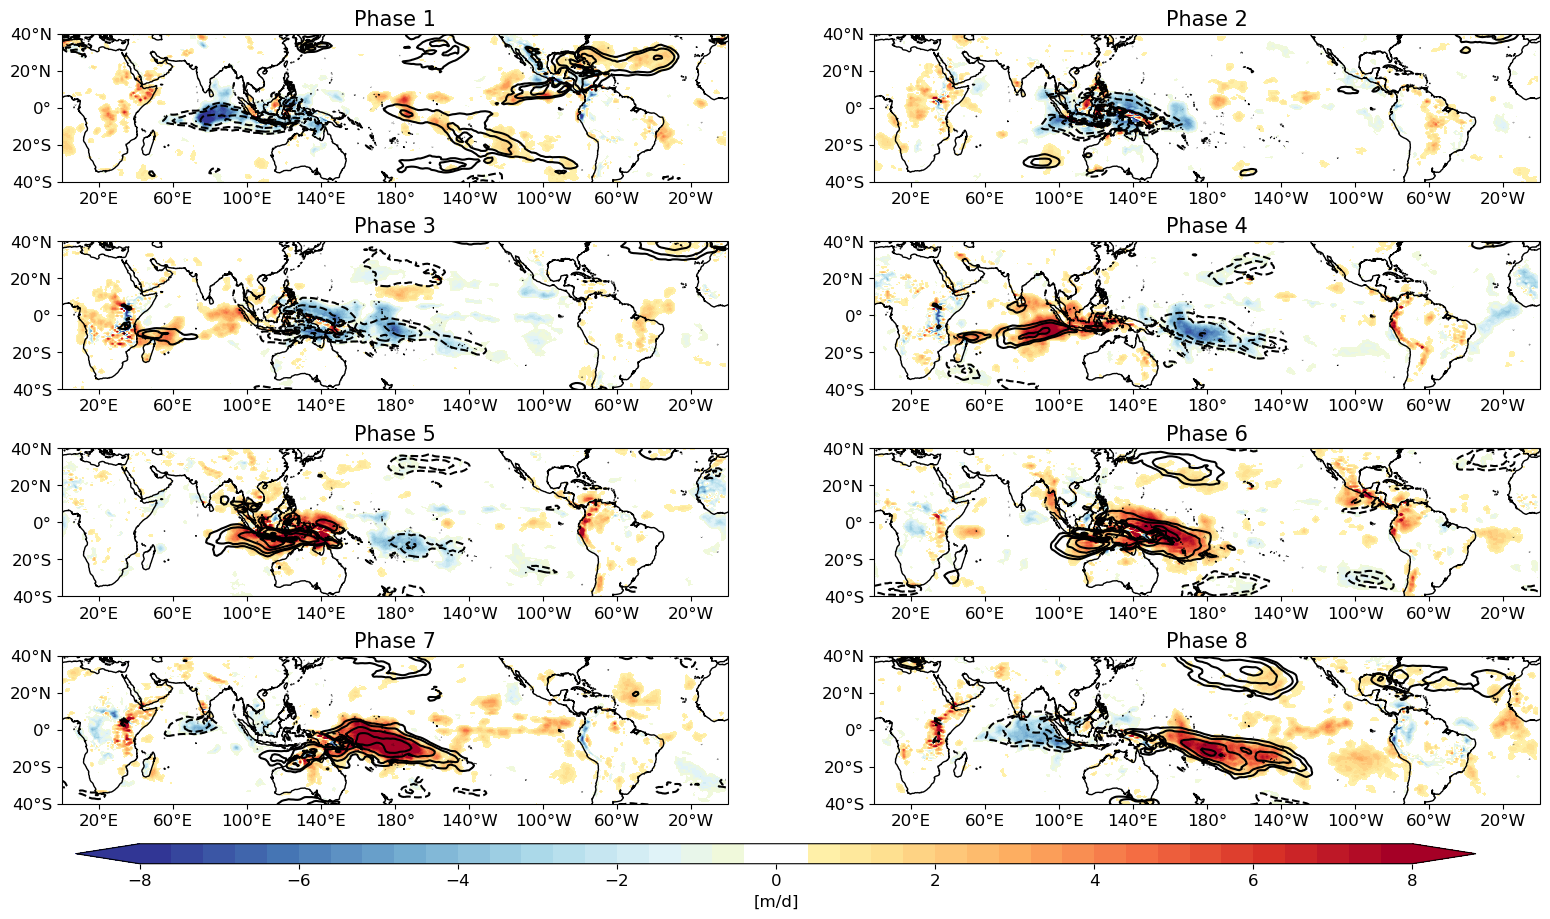

In [7]:
# Setup remains largely the same
# Define clevs and colormap for your data here
# Parameters and data setup (remains the same)
clevs = np.arange(-8, 8.4, .4)
bluey = mpl.cm.get_cmap('RdYlBu_r', len(clevs))
newcolors = bluey(np.linspace(0, 1, len(clevs)))
nnn = int(np.floor(newcolors.shape[0]/2))
newcolors[nnn] = newcolors[nnn]/newcolors[nnn]
newcolors[nnn+1] = newcolors[nnn+1]/newcolors[nnn+1]
newcolors[nnn-1] = newcolors[nnn-1]/newcolors[nnn-1]
cmapzzz = ListedColormap(newcolors)

#begin fig
fig = plt.figure(figsize=(20, 10))  # Adjusted figure size for 8 panels
proj = ccrs.PlateCarree(central_longitude=180)

lvlv = 1000
varvar = 'Nudge_U'
varvar2 = 'U'
varvarm2 = 'NDJFM_Um'
Phase_Incs = xr.open_dataset('./Increments_by_Phase_UV.nc')
for phs in range(1,9):
    Phase_Incs_mjo = xr.open_dataset(f"./MJO_phase_increment_{phs:03}.nc")
    ax = plt.subplot(4, 2, phs, projection=proj)  # Dynamic subplot creation
    ax.coastlines('50m')

    # Subsampling for quiver plot clarity
    skip = (slice(None, None, 7), slice(None, None, 7))
   
    pfield = ((Phase_Incs_mjo[varvar].sel(lev=lvlv, method='nearest'))*86400)
    pfield_cont = ((Phase_Incs[varvar2].sel(phase=phs, lev=lvlv, method='nearest')-Phase_Incs.sel(lev=lvlv, method='nearest')[varvarm2]))

    # Plotting
    bb = ax.contourf(pfield['lon'] - 180, pfield['lat'], pfield, levels=clevs, cmap=cmapzzz, transform=proj, extend='both')
    q = ax.contour(pfield['lon'] - 180, pfield['lat'], pfield_cont, transform=proj,levels=[-5,-4,-3,-2,-1.5,1.5,2,3,4,5],colors='k')
    
    # Set ticks, labels, and title dynamically
    ax.set_xticks([20, 60, 100, 140, 180, 220, 260, 300, 340], crs=ccrs.PlateCarree())
    ax.set_yticks(np.arange(-60, 70, 20), crs=ccrs.PlateCarree())
    ax.xaxis.set_major_formatter(LongitudeFormatter(zero_direction_label=True, number_format='.0f'))
    ax.yaxis.set_major_formatter(LatitudeFormatter())
    ax.tick_params(labelsize=12)
    ax.set_extent([0, 360, -40, 40], crs=ccrs.PlateCarree())
    ax.set_title(f'Phase {phs}', fontsize=15)  # Dynamic title

    
# Add a colorbar at the bottom of the figure
# Use the axes_list for positioning
cbar_ax = fig.add_axes([0.15, 0.05, 0.7, 0.02])  # [left, bottom, width, height] in figure coordinate
cbar=fig.colorbar(bb, cax=cbar_ax, orientation='horizontal', label='[m/d]')
cbar.ax.tick_params(labelsize=12)
cbar.set_label(label='[m/d]',fontsize=12)
fig.subplots_adjust(hspace=0.4,wspace=0.1)  # Adjust spacing as needed
plt.show()

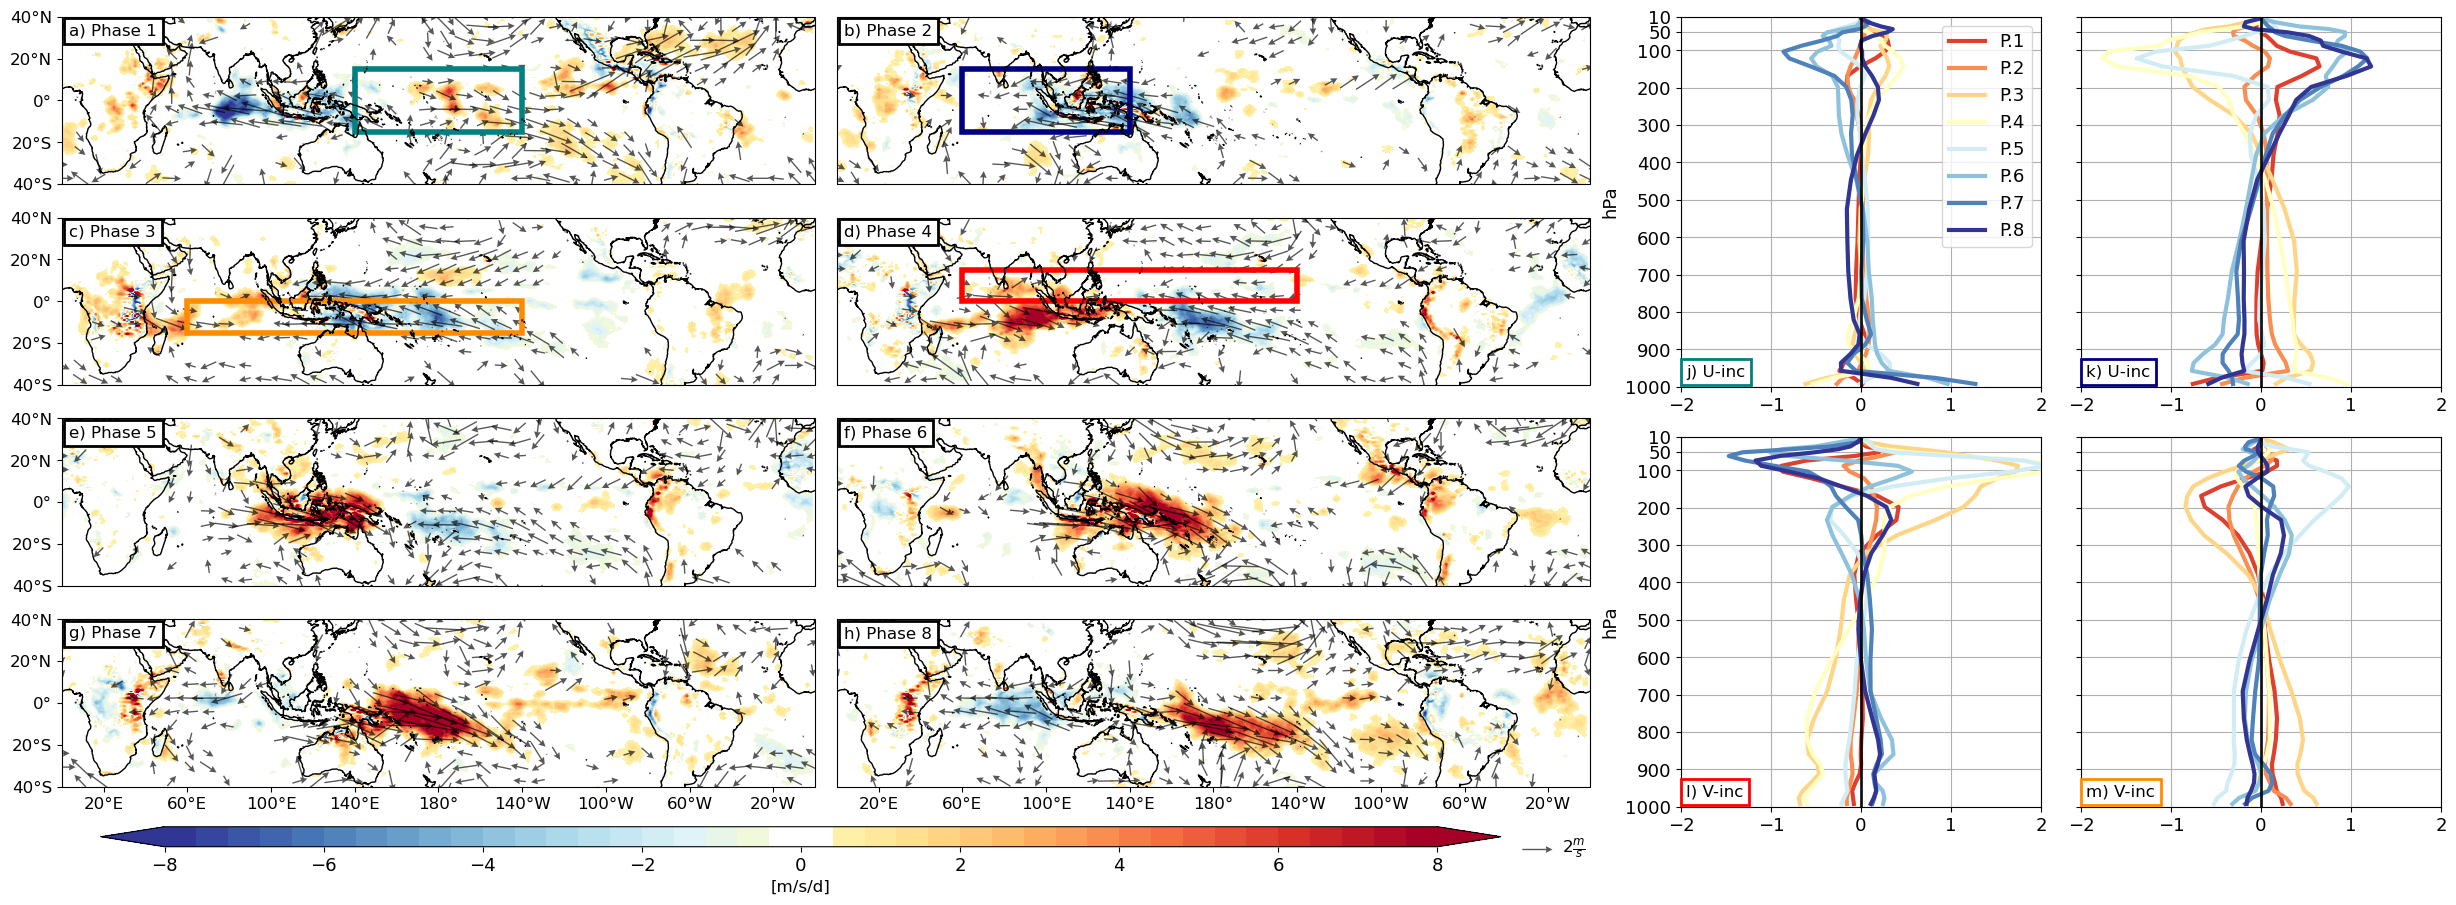

In [127]:
from matplotlib.patches import Rectangle

# Setup remains largely the same
# Define clevs and colormap for your data here
# Parameters and data setup (remains the same)
clevs = np.arange(-8, 8.4, .4)
bluey = mpl.cm.get_cmap('RdYlBu_r', len(clevs))
newcolors = bluey(np.linspace(0, 1, len(clevs)))
nnn = int(np.floor(newcolors.shape[0]/2))
newcolors[nnn] = newcolors[nnn]/newcolors[nnn]
newcolors[nnn+1] = newcolors[nnn+1]/newcolors[nnn+1]
newcolors[nnn-1] = newcolors[nnn-1]/newcolors[nnn-1]
cmapzzz = ListedColormap(newcolors)

#begin fig
fig = plt.figure(figsize=(20, 10))  # Adjusted figure size for 8 panels
proj = ccrs.PlateCarree(central_longitude=180)

lvlv = 1000
varvar = 'Nudge_U'
varvar2 = 'U'
varvarm2 = 'NDJFM_Vm'
Phase_Incs = xr.open_dataset('./Increments_by_Phase_UV.nc')

fig_dict = {1:'a',2:'b',3:'c',4:'d',5:'e',6:'f',7:'g',8:'h',9:'i'}

for phs in range(1,9):
    Phase_Incs_mjo = xr.open_dataset(f"./MJO_phase_increment_{phs:03}.nc")
    ax = plt.subplot(4, 2, phs, projection=proj)  # Dynamic subplot creation
    ax.coastlines('50m')


    u = ((Phase_Incs['U'].sel(phase=phs, lev=lvlv, method='nearest')-Phase_Incs.sel(lev=lvlv, method='nearest')['NDJFM_Um']))
    v = ((Phase_Incs['V'].sel(phase=phs, lev=lvlv, method='nearest')-Phase_Incs.sel(lev=lvlv, method='nearest')['NDJFM_Vm']))

    # Apply the mask: Replace vectors with small magnitudes with NaNs
    mask = np.sqrt(u**2 + v**2) < 0.75
    u = np.where(mask, np.nan, u)
    v = np.where(mask, np.nan, v)

    lon, lat = np.meshgrid(pfield['lon'].values, pfield['lat'].values)


    # Subsampling for quiver plot clarity
    skip = (slice(None, None, 7), slice(None, None, 7))
   
    pfield = ((Phase_Incs_mjo[varvar].sel(lev=lvlv, method='nearest'))*86400)
    pfield_cont = ((Phase_Incs[varvar2].sel(phase=phs, lev=lvlv, method='nearest')-Phase_Incs.sel(lev=lvlv, method='nearest')[varvarm2]))
    
    lon, lat = np.meshgrid(pfield['lon'].values, pfield['lat'].values)
    # Plotting
    bb = ax.contourf(pfield['lon'] - 180, pfield['lat'], pfield, levels=clevs, cmap=cmapzzz, transform=proj, extend='both')
    
    q = ax.quiver(lon[skip], lat[skip], u[skip], v[skip],pivot="middle", transform=ccrs.PlateCarree(),
                  color='black', scale=50, alpha=0.66,linewidths=0.01, width=0.0018,headwidth=5)

    if phs == 8:
        qk = ax.quiverkey(q, 0.95, -.37, 2, r'$2 \frac{m}{s}$', labelpos='E',
                       transform=ax.transAxes, color='black', fontproperties={'size':12})
    
    # Set ticks, labels, and title dynamically

    if (phs == 7) | (phs == 8):
        ax.set_xticks([20, 60, 100, 140, 180, 220, 260, 300, 340], crs=ccrs.PlateCarree())
    else:
        ax.set_xticks([], crs=ccrs.PlateCarree())
    
    if phs%2 !=0:
        ax.set_yticks(np.arange(-60, 70, 20), crs=ccrs.PlateCarree())
    else:
        ax.set_yticks([], crs=ccrs.PlateCarree())

    if phs ==1:
        rectangle = Rectangle((140, -15), 80, 30, transform=ccrs.PlateCarree(), 
                      edgecolor='teal', facecolor='none',linewidth=4)
        ax.add_patch(rectangle)
    if phs ==2:
        rectangle = Rectangle((60, -15), 80, 30, transform=ccrs.PlateCarree(), 
                      edgecolor='navy', facecolor='none',linewidth=4)
        ax.add_patch(rectangle)
    if phs==3:
        rectangle = Rectangle((60, -15), 160, 15, transform=ccrs.PlateCarree(), 
                      edgecolor='darkorange', facecolor='none',linewidth=4)
        ax.add_patch(rectangle)
    if phs==4:
        rectangle = Rectangle((60, 0), 160, 15, transform=ccrs.PlateCarree(), 
                      edgecolor='red', facecolor='none',linewidth=4)
        ax.add_patch(rectangle)

    ax.xaxis.set_major_formatter(LongitudeFormatter(zero_direction_label=True, number_format='.0f'))
    ax.yaxis.set_major_formatter(LatitudeFormatter())
    ax.tick_params(labelsize=12)
    ax.set_extent([0, 360, -40, 40], crs=ccrs.PlateCarree())
    # ax.set_title(f'Phase {phs}', fontsize=15)  # Dynamic title
    bbox_props = dict(fc="white", ec="k", lw=2)
    ax.text(0.01, 0.96, f'{fig_dict[phs]}) Phase {phs}', transform=ax.transAxes, ha='left', va='top', fontsize=12, bbox=bbox_props)
    
# Add a colorbar at the bottom of the figure
# Use the axes_list for positioning
cbar_ax = fig.add_axes([0.15, 0.05, 0.7, 0.02])  # [left, bottom, width, height] in figure coordinate
cbar=fig.colorbar(bb, cax=cbar_ax, orientation='horizontal', label='[m/s/d]')
cbar.ax.tick_params(labelsize=13)
cbar.set_label(label='[m/s/d]', fontsize=12)
colors = plt.cm.RdYlBu(np.linspace(0,1,9))

ax10 = fig.add_axes([0.94,.51, 0.18, 0.37]) 
for phs in range(1,9):
    Phase_Incs_mjo = xr.open_dataset(f"./MJO_phase_increment_{phs:03}.nc")
    ax10.plot(((Phase_Incs_mjo.sel(lat=slice(-15,15),lon=slice(140,220))).mean(['lat','lon'])['Nudge_U']*86400).rolling(lev=3, center=True,min_periods=1).mean(),
             Phase_Incs_mjo['lev'],label=f'P.{phs}',linewidth=3, color=colors[phs])

ax10.plot([0,0],[0,1000],linewidth=2, alpha=0.9, color='k')
ax10.set_ylim([10,1000])
ax10.set_yticks([1000,900,800,700,600,500,400,300,200,100,50,10])
# ax1.set_xticks(np.arange(-80,80,20))
ax10.set_xlim([-2,2])
ax10.set_ylabel('hPa',fontsize=13)
ax10.invert_yaxis()
ax10.legend(fontsize=13)
ax10.tick_params(labelsize=13) 
ax10.grid(True)
bbox_props = dict(fc="white", ec="teal", lw=2)
ax10.text(0.015, 0.02, f'j) U-inc', transform=ax10.transAxes, ha='left', va='bottom', fontsize=12, bbox=bbox_props)
    

ax11 = fig.add_axes([0.94+.2,.51, 0.18, 0.37])  
for phs in range(1,9):
    Phase_Incs_mjo = xr.open_dataset(f"./MJO_phase_increment_{phs:03}.nc")
    ax11.plot(((Phase_Incs_mjo.sel(lat=slice(-15,15),lon=slice(60,140))).mean(['lat','lon'])['Nudge_U']*86400).rolling(lev=3, center=True,min_periods=1).mean(),
             Phase_Incs_mjo['lev'],label=f'P.{phs}',linewidth=3, color=colors[phs])

ax11.plot([0,0],[0,1000],linewidth=2, alpha=0.9, color='k')
ax11.set_ylim([10,1000])
ax11.set_yticks([1000,900,800,700,600,500,400,300,200,100,50,10],'')
ax11.set_xlim([-2,2])
ax11.invert_yaxis()
ax11.tick_params(labelsize=13) 
ax11.grid(True)
bbox_props = dict(fc="white", ec="navy", lw=2)
ax11.text(0.015, 0.02, f'k) U-inc', transform=ax11.transAxes, ha='left', va='bottom', fontsize=12, bbox=bbox_props)


ax12 = fig.add_axes([0.94,.09, 0.18, 0.37])
for phs in range(1,9):
    Phase_Incs_mjo = xr.open_dataset(f"./MJO_phase_increment_{phs:03}.nc")
    ax12.plot(((Phase_Incs_mjo.sel(lat=slice(0,15),lon=slice(60,220))).mean(['lat','lon'])['Nudge_V']*86400).rolling(lev=3, center=True,min_periods=1).mean(),
             Phase_Incs_mjo['lev'],label=f'P.{phs}',linewidth=3, color=colors[phs])

ax12.plot([0,0],[0,1000],linewidth=2, alpha=0.9, color='k')
ax12.set_ylim([10,1000])
ax12.set_yticks([1000,900,800,700,600,500,400,300,200,100,50,10])
ax12.set_xlim([-2,2])
ax12.set_ylabel('hPa',fontsize=13)
ax12.invert_yaxis()
ax12.tick_params(labelsize=13) 
ax12.grid(True)
bbox_props = dict(fc="white", ec="red", lw=2)
ax12.text(0.015, 0.02, f'l) V-inc', transform=ax12.transAxes, ha='left', va='bottom', fontsize=12, bbox=bbox_props)


ax13 = fig.add_axes([0.94+.2,.09, 0.18, 0.37])  

for phs in range(1,9):
    Phase_Incs_mjo = xr.open_dataset(f"./MJO_phase_increment_{phs:03}.nc")
    ax13.plot(((Phase_Incs_mjo.sel(lat=slice(-15,0),lon=slice(60,220))).mean(['lat','lon'])['Nudge_V']*86400).rolling(lev=3, center=True,min_periods=1).mean(),
             Phase_Incs_mjo['lev'],label=f'P.{phs}',linewidth=3, color=colors[phs])

ax13.plot([0,0],[0,1000],linewidth=2, alpha=0.9, color='k')
ax13.set_ylim([10,1000])
ax13.set_yticks([1000,900,800,700,600,500,400,300,200,100,50,10],'')
ax13.set_xlim([-2,2])
ax13.invert_yaxis()
ax13.tick_params(labelsize=13) 
ax13.grid(True)
bbox_props = dict(fc="white", ec="darkorange", lw=2)
ax13.text(0.015, 0.02, f'm) V-inc', transform=ax13.transAxes, ha='left', va='bottom', fontsize=12, bbox=bbox_props)


fig.subplots_adjust(hspace=0.2, wspace=0)  # Adjust spacing as needed
plt.savefig(f'./quiver_composite_nudging_{lvlv}mb.png',bbox_inches='tight',dpi=400)
plt.show()

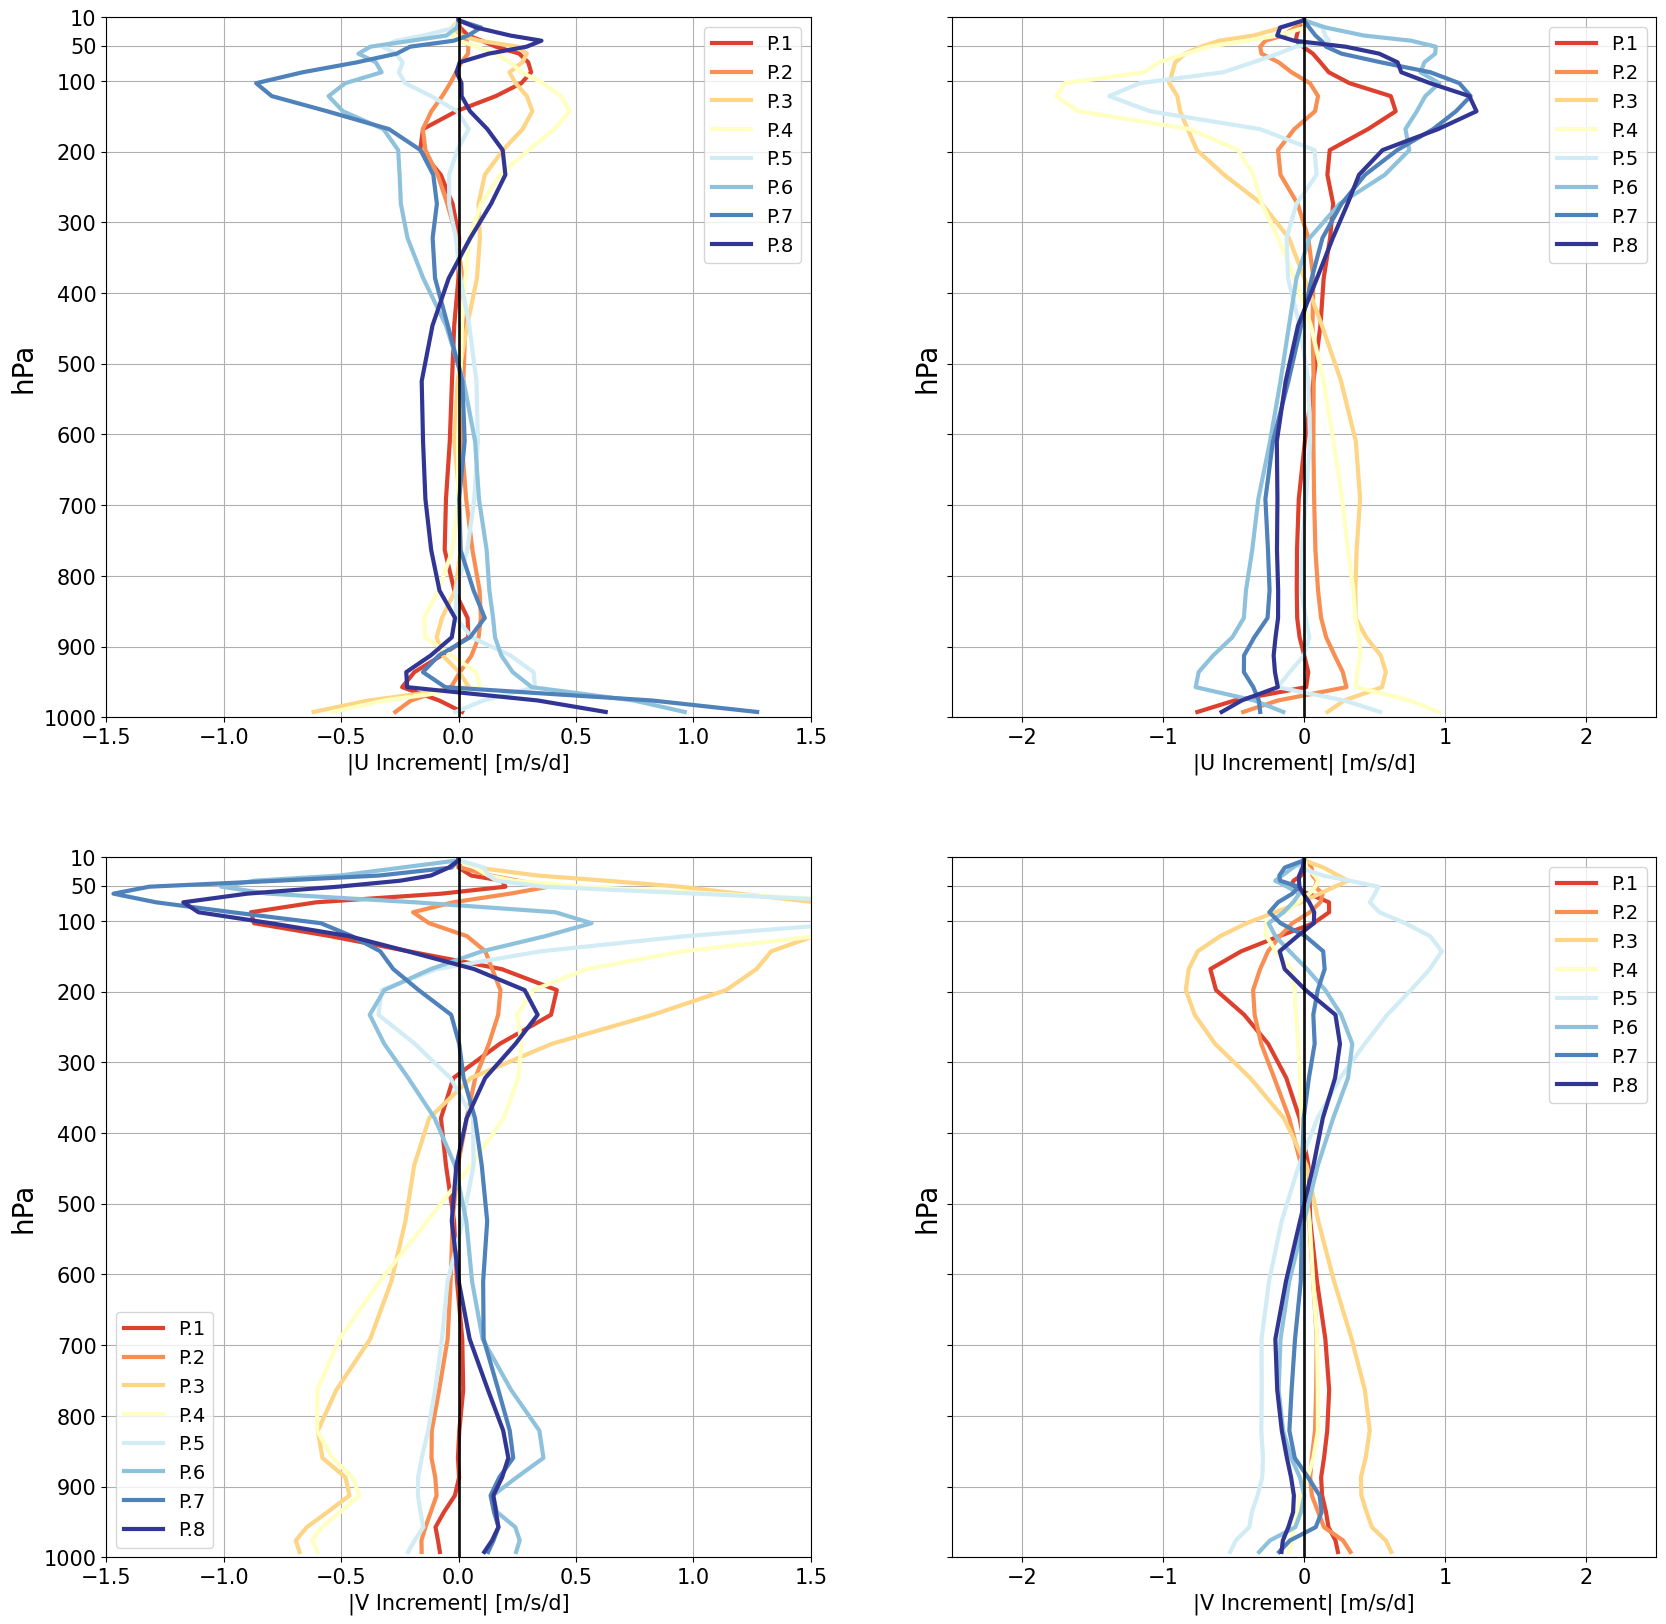

In [87]:
fig, axes = plt.subplots(2, 2, sharey=True, figsize=(20,20))
colors = plt.cm.RdYlBu(np.linspace(0,1,9))
ax1,ax2,ax3,ax4=axes.flatten()
axes.flatten()

for phs in range(1,9):
    Phase_Incs_mjo = xr.open_dataset(f"./MJO_phase_increment_{phs:03}.nc")
    ax1.plot(((Phase_Incs_mjo.sel(lat=slice(-15,15),lon=slice(140,220))).mean(['lat','lon'])['Nudge_U']*86400).rolling(lev=3, center=True,min_periods=1).mean(),
             Phase_Incs_mjo['lev'],label=f'P.{phs}',linewidth=3, color=colors[phs])

ax1.plot([0,0],[0,1000],linewidth=2, alpha=0.9, color='k')
ax1.set_ylim([10,1000])
ax1.set_yticks([1000,900,800,700,600,500,400,300,200,100,50,10])
# ax1.set_xticks(np.arange(-80,80,20))
ax1.set_xlim([-1.5,1.5])
ax1.set_xlabel('|U Increment| [m/s/d]',fontsize=15)
ax1.set_ylabel('hPa',fontsize=20)
ax1.invert_yaxis()
ax1.legend(fontsize=14)
ax1.tick_params(labelsize=15) 
ax1.grid(True)


for phs in range(1,9):
    Phase_Incs_mjo = xr.open_dataset(f"./MJO_phase_increment_{phs:03}.nc")
    ax2.plot(((Phase_Incs_mjo.sel(lat=slice(-15,15),lon=slice(60,140))).mean(['lat','lon'])['Nudge_U']*86400).rolling(lev=3, center=True,min_periods=1).mean(),
             Phase_Incs_mjo['lev'],label=f'P.{phs}',linewidth=3, color=colors[phs])

ax2.plot([0,0],[0,1000],linewidth=2, alpha=0.9, color='k')
ax2.set_ylim([10,1000])
ax2.set_yticks([1000,900,800,700,600,500,400,300,200,100,50,10])
# ax1.set_xticks(np.arange(-80,80,20))
ax2.set_xlim([-2.5,2.5])
ax2.set_xlabel('|U Increment| [m/s/d]',fontsize=15)
ax2.set_ylabel('hPa',fontsize=20)
ax2.invert_yaxis()
ax2.legend(fontsize=14)
ax2.tick_params(labelsize=15) 
ax2.grid(True)


for phs in range(1,9):
    Phase_Incs_mjo = xr.open_dataset(f"./MJO_phase_increment_{phs:03}.nc")
    ax3.plot(((Phase_Incs_mjo.sel(lat=slice(0,15),lon=slice(60,220))).mean(['lat','lon'])['Nudge_V']*86400).rolling(lev=3, center=True,min_periods=1).mean(),
             Phase_Incs_mjo['lev'],label=f'P.{phs}',linewidth=3, color=colors[phs])

ax3.plot([0,0],[0,1000],linewidth=2, alpha=0.9, color='k')
ax3.set_ylim([10,1000])
ax3.set_yticks([1000,900,800,700,600,500,400,300,200,100,50,10])
# ax1.set_xticks(np.arange(-80,80,20))
ax3.set_xlim([-1.5,1.5])
ax3.set_xlabel('|V Increment| [m/s/d]',fontsize=15)
ax3.set_ylabel('hPa',fontsize=20)
ax3.invert_yaxis()
ax3.legend(fontsize=14)
ax3.tick_params(labelsize=15) 
ax3.grid(True)


for phs in range(1,9):
    Phase_Incs_mjo = xr.open_dataset(f"./MJO_phase_increment_{phs:03}.nc")
    ax4.plot(((Phase_Incs_mjo.sel(lat=slice(-15,0),lon=slice(60,220))).mean(['lat','lon'])['Nudge_V']*86400).rolling(lev=3, center=True,min_periods=1).mean(),
             Phase_Incs_mjo['lev'],label=f'P.{phs}',linewidth=3, color=colors[phs])

ax4.plot([0,0],[0,1000],linewidth=2, alpha=0.9, color='k')
ax4.set_ylim([10,1000])
ax4.set_yticks([1000,900,800,700,600,500,400,300,200,100,50,10])
# ax1.set_xticks(np.arange(-80,80,20))
ax4.set_xlim([-2.5,2.5])
ax4.set_xlabel('|V Increment| [m/s/d]',fontsize=15)
ax4.set_ylabel('hPa',fontsize=20)
ax4.invert_yaxis()
ax4.legend(fontsize=14)
ax4.tick_params(labelsize=15) 
ax4.grid(True)

# ax1.text(0.02, 0.02, f'U Wind - {SEAS}', transform=ax1.transAxes, ha='left', va='bottom', fontsize=15, bbox=bbox_props)



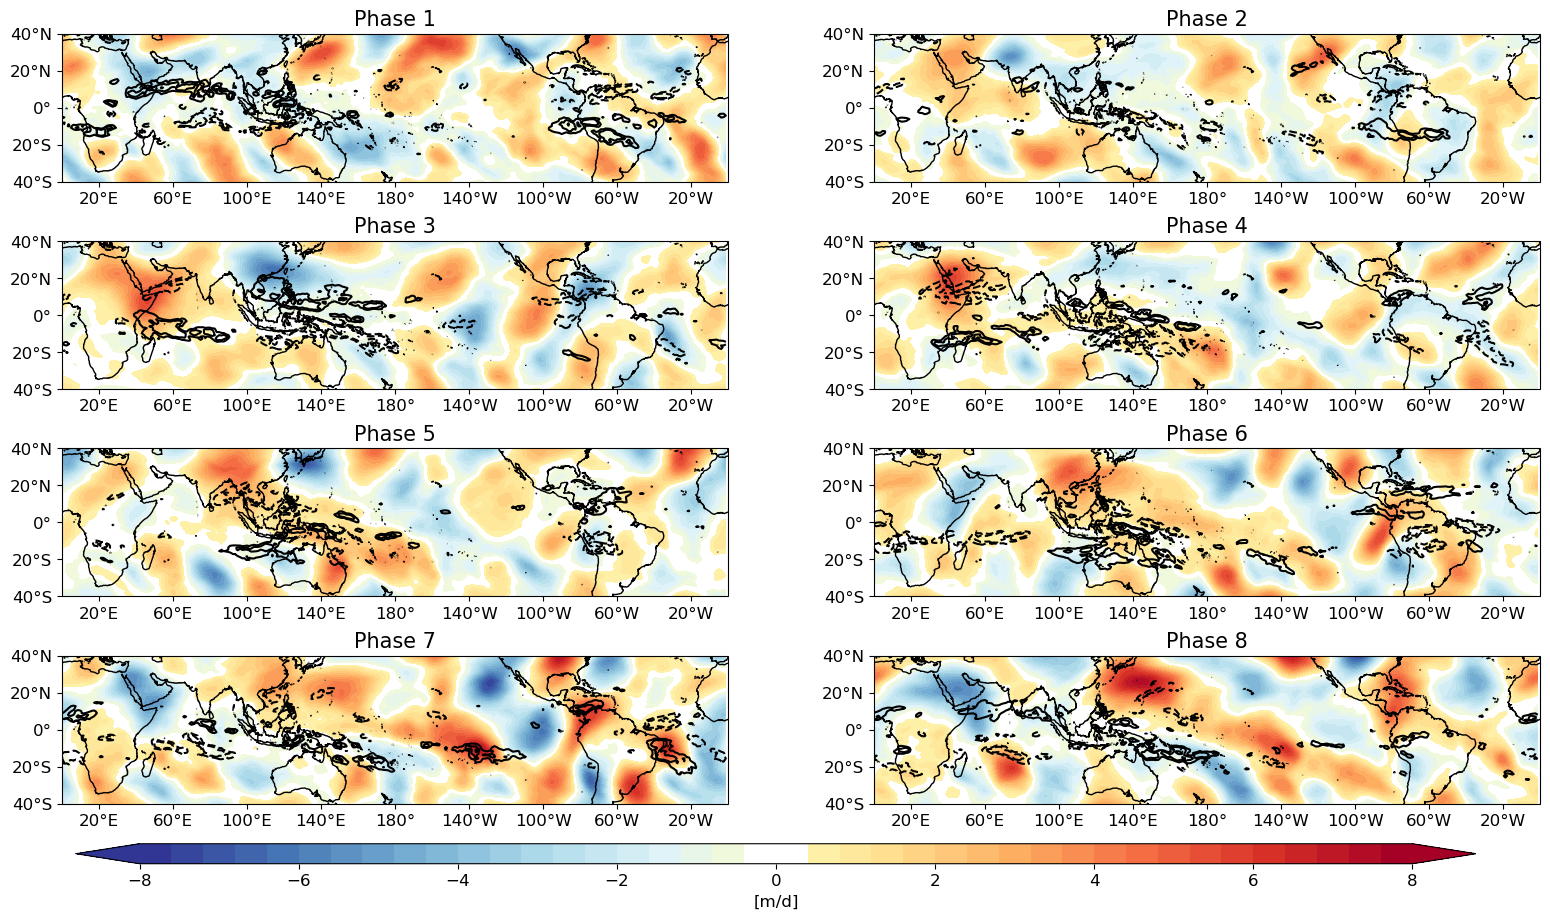

In [80]:
Phase_Incs = xr.open_dataset('./Increments_by_Phase_UV.nc')

# Setup remains largely the same
# Define clevs and colormap for your data here
# Parameters and data setup (remains the same)
clevs = np.arange(-8, 8.4, .4)
bluey = mpl.cm.get_cmap('RdYlBu_r', len(clevs))
newcolors = bluey(np.linspace(0, 1, len(clevs)))
nnn = int(np.floor(newcolors.shape[0]/2))
newcolors[nnn] = newcolors[nnn]/newcolors[nnn]
newcolors[nnn+1] = newcolors[nnn+1]/newcolors[nnn+1]
newcolors[nnn-1] = newcolors[nnn-1]/newcolors[nnn-1]
cmapzzz = ListedColormap(newcolors)

#begin fig
fig = plt.figure(figsize=(20, 10))  # Adjusted figure size for 8 panels
proj = ccrs.PlateCarree(central_longitude=180)

lvlv = 200
varvar = 'V'
varvarm = 'NDJFM_Vm'
for phs in range(1,9):
    Phase_Incs_mjo = xr.open_dataset(f"./MJO_phase_increment_{phs:03}.nc")
    ax = plt.subplot(4, 2, phs, projection=proj)  # Dynamic subplot creation
    ax.coastlines('50m')

   
    pfield = ((Phase_Incs[varvar].sel(phase=phs, lev=lvlv, method='nearest')-Phase_Incs.sel(lev=lvlv, method='nearest')[varvarm]))

    # Plotting
    bb = ax.contourf(pfield['lon'] - 180, pfield['lat'], pfield, levels=clevs, cmap=cmapzzz, transform=proj, extend='both')
    lon2d, lat2d = np.meshgrid(pfield['lon'], pfield['lat'])
    # Create the quiver plot
    u = np.array(Phase_Incs_mjo['Nudge_U'].sel(lev=lvlv,method='nearest'))
    v = np.array(Phase_Incs_mjo['Nudge_V'].sel(lev=lvlv,method='nearest'))
    

        # Calculate wind speed
    wind_speed = np.sqrt(u**2 + v**2)
    
    # Create a mask for non-zero wind speeds
    mask = wind_speed > 0.00003
    
    # Apply the mask to u, v, and the coordinate grids
    u_nonzero = np.ma.masked_where(~mask, u)
    v_nonzero = np.ma.masked_where(~mask, v)
    lon2d_nonzero = np.ma.masked_where(~mask, lon2d)
    lat2d_nonzero = np.ma.masked_where(~mask, lat2d)

    q = ax.contour(lon2d-180,lat2d,v*86400,levels=[-6,-3,3,6],colors='k')
    # q = ax.quiver(lon2d_nonzero-180, lat2d_nonzero, u_nonzero, v_nonzero, scale=20)

    # # Add a key to the quiver plot
    # qk = ax.quiverkey(q, X=0.1, Y=1.05, U=10, label='10 m/s', labelpos='E')

    
    # Set ticks, labels, and title dynamically
    ax.set_xticks([20, 60, 100, 140, 180, 220, 260, 300, 340], crs=ccrs.PlateCarree())
    ax.set_yticks(np.arange(-60, 70, 20), crs=ccrs.PlateCarree())
    ax.xaxis.set_major_formatter(LongitudeFormatter(zero_direction_label=True, number_format='.0f'))
    ax.yaxis.set_major_formatter(LatitudeFormatter())
    ax.tick_params(labelsize=12)
    ax.set_extent([0, 360, -40, 40], crs=ccrs.PlateCarree())
    ax.set_title(f'Phase {phs}', fontsize=15)  # Dynamic title

    
# Add a colorbar at the bottom of the figure
# Use the axes_list for positioning
cbar_ax = fig.add_axes([0.15, 0.05, 0.7, 0.02])  # [left, bottom, width, height] in figure coordinate
cbar=fig.colorbar(bb, cax=cbar_ax, orientation='horizontal', label='[m/d]')
cbar.ax.tick_params(labelsize=12)
cbar.set_label(label='[m/d]',fontsize=12)
fig.subplots_adjust(hspace=0.4,wspace=0.1)  # Adjust spacing as needed
plt.show()


In [454]:
bootstrap = np.arange(len(DSsum_all))
DSsum_save = xr.concat(DSsum_all,dim='bootstrap')
DSsum_save['bootstrap']=bootstrap
DSsum_save.to_netcdf('./sum_save_BSincrements.nc')

In [456]:
DSsum_save.to_netcdf('./sum_save_BSincrements.nc')

In [ ]:
# Assuming mean_phase_u and mean_phase_v are lists of xarray DataArrays
# Create a coordinate array for "phase"
phases = np.arange(stphas, endphas)  # Adjust the range as necessary

# Combine mean_phase_u and mean_phase_v into DataArrays with "phase" as a new coordinate
mean_phase_u_da = xr.concat(mean_phase_u, dim='phase')
mean_phase_v_da = xr.concat(mean_phase_v, dim='phase')

# # Assign the "phase" coordinate
mean_phase_u_da['phase'] = phases
mean_phase_v_da['phase'] = phases

Phase_Incs = xr.merge([mean_phase_v_da, mean_phase_u_da])
Phase_Incs = xr.merge([Phase_Incs,NDJFM_DS1_mean])
Phase_Incs.to_netcdf('./Random_Selections_Increments.nc')

In [457]:
f'./sum_save_BSincrements_{bsbs}.nc'

'./sum_save_BSincrements_2.nc'

In [322]:
DS = xr.open_dataset('/glade/derecho/scratch/wchapman/f.e.FTORCHmjo_mean_exp001/run/f.e.FTORCHmjo_mean_exp001.cam.h1.1979-01-01-57600.nc')

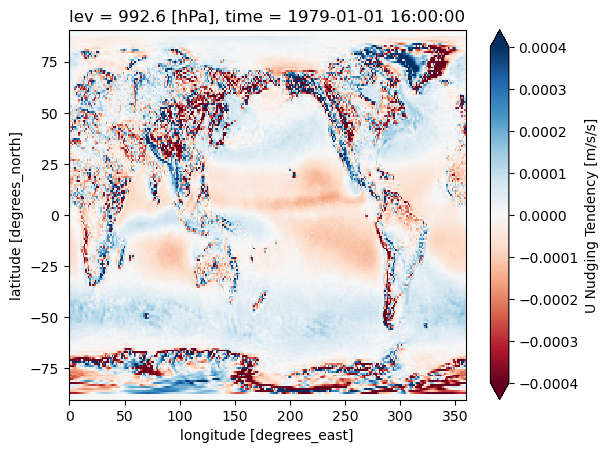

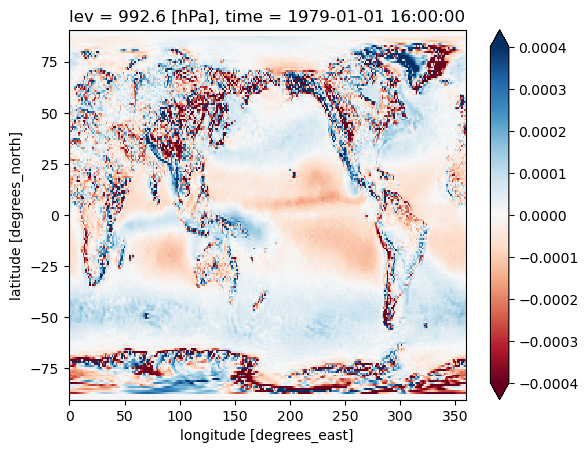

In [338]:
(DS['Nudge_U'].squeeze().sel(lev=1000,method='nearest')).plot(vmin=-0.0004,vmax=0.0004,cmap='RdBu')
plt.show()
(DS['Nudge_U'].squeeze().sel(lev=1000,method='nearest')+DS['cb24mjocnn_U'].squeeze().sel(lev=1000,method='nearest')).plot(vmin=-0.0004,vmax=0.0004,cmap='RdBu')
plt.show()

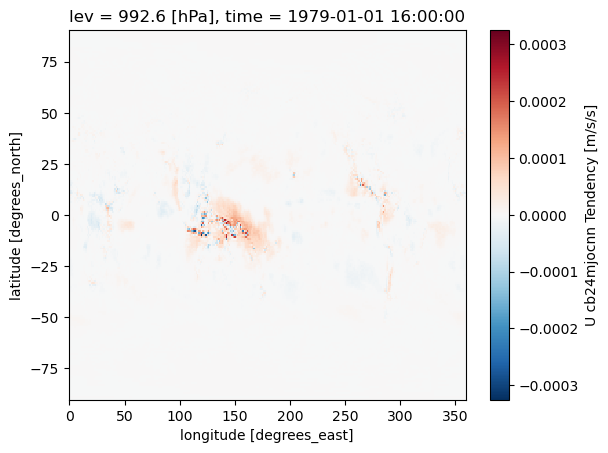

In [333]:
DS['cb24mjocnn_U'].squeeze().sel(lev=1000,method='nearest').plot()